In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections
import requests
import pickle
import json
import datetime
import random

seed=117
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


## Protein Disorder Prediction

### Data set-up

Import drive, so that preprocessed data can be used in Notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Quick access to preprocessed data, instead of downloading it each time Notebook is opened.

In [ ]:

def read_sequences():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/sequence_data.json', 'r') as infile:
    return json.load(infile)

def read_cleaned_pandas_data():
  return pd.read_json('/content/drive/My Drive/Colab Notebooks/diss_files/idr_pandas_table.json')

def read_onehot():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/onehot_data.json', 'r') as infile:
    onehot_map = json.load(infile)
    onehot_map.update((acc, np.array(onehot)) for acc, onehot in onehot_map.items())
    return onehot_map

def read_pssms():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/pssm_data.json', 'r') as infile:
    pssm_map = json.load(infile)
    pssm_map.update((acc, np.array(pssm)) for acc, pssm in pssm_map.items())
    return pssm_map

def read_homo_solution():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/homo_solution.json', 'r') as infile:
    return json.load(infile)

# Protein sequences
protein_sequences_n_ids = read_sequences()
# IDRs
pandas_data_IDRs = read_cleaned_pandas_data()
# One-hot features
onehot_map = read_onehot()
# PSSM features
pssm_map = read_pssms()
# Randomly sampled dataset split from pre-processing.
# Data leakage prevention included.
non_leaking_dataset_split = read_homo_solution()

### Dataset class for our data. 
- Takes in pandas data (usually full TSV).
- The amino acid vectorising map.
- A dictionary mapping protein accession numbers to their sequence (generated from preprocessing).

In [ ]:
class DisProtDataset(Dataset):
    def __init__(self, pandas_table, vector_map, protein_sequences, ids, transform=None):
        self.disorder_prot = pandas_table
        self.vectorised_seqs = vector_map
        self.sequences = protein_sequences
        self.ids = ids
        self.tranform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # Protein accession number - key identifier
        acc = self.ids[idx]
        # Each row must have a unique accession number, hence we can 0 index this list
        dataframe_idx = self.disorder_prot.index[self.disorder_prot['acc'] == acc].tolist()[0]
        idrs = self.disorder_prot['disordered_regions'].loc[dataframe_idx]
        
        # Get vectorised sequence
        vectorised_protein_sequence = self.vectorised_seqs.get(acc)

        # Get protein sequence
        protein_sequence = self.sequences.get(acc)
        
        # Create order/disorder label
        disorder_label = np.zeros(len(protein_sequence))
        for (start, end) in idrs:
          disorder_label[start-1:end] = 1

        get_dict = {'acc': acc, 'seq': vectorised_protein_sequence, 'label': disorder_label}
        return get_dict

### Training model, given DisProt dataset

Separate train/validation/test datasets, with a 60/20/20 split.

One-hot feature encoding.

In [ ]:
train_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Train'])
validation_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Validation'])
test_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Test'])

train_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

validation_loader = DataLoader(validation_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

PSSM feature encoding.

In [ ]:
train_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Train'])
validation_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Validation'])
test_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Test'])

train_pssm_loader = DataLoader(train_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

validation_pssm_loader = DataLoader(validation_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

test_pssm_loader = DataLoader(test_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

### Working with a PyTorch NN. FCN model

In [ ]:
class FCN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(20, 10, 21, padding=10)
        self.conv2 = nn.Conv1d(10, 10, 21, padding=10)
        self.conv3 = nn.Conv1d(10, 10, 21, padding=10)
        self.do1 = nn.Dropout(0.5)
        self.conv4 = nn.Conv1d(10, 10, 21, padding=10)
        self.do2 = nn.Dropout(0.5)
        self.conv5 = nn.Conv1d(10, 1, 21, padding=10)
        self.do3 = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.do1(F.relu(self.conv3(x)))
        x = self.do2(F.relu(self.conv4(x)))
        x = self.do3(self.conv5(x))
        # Removal of final activation function due to BCE With Logits Loss being used
        #x = torch.sigmoid(self.conv5(x))
        return x

#### Evaluating with the Matthews correlation coefficient.
- This can be used with the validation dataset each epoch.
- This is used to evaluate the test dataset.

MCC = $\frac{(TP * TN) - (FP * FN)}{\sqrt{(TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)}}$

Where the variables are:
- TP - when a disordered protein is classified as disordered. A 1 is said to be a 1.
- FP - when an ordered protein is classified as disordered.   A 0 is said to be a 1.
- TN - when an ordered protein is classified as ordered.      A 0 is said to be a 0.
- FN - when an disordered protein is classified as ordered.   A 1 is said to be a 0.

In [ ]:
# Turns the prediction to a list of ordered/disordered (0/1) predictions
def pred_round(predicted_label):
  predicted_label[predicted_label>=0.5] = 1
  predicted_label[predicted_label<0.5] = 0
  return predicted_label

def calc_MCC(predicted_label, true_label):
  # Calculating TN value
  # Sum as True values take on the value of 1
  TN = (true_label[predicted_label == 0] == 0).sum()
  # Calculating FN
  FN = (true_label[predicted_label == 0] == 1).sum()
  # Calculating TP
  TP = (true_label[predicted_label == 1] == 1).sum()
  # Calculating FP
  FP = (true_label[predicted_label == 1] == 0).sum()

  num = (TP * TN) - (FP * FN)
  den = torch.sqrt( (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) )
  if den == 0:
    return 0
  MCC = num / den
  return MCC

#### Counteracting the unbalanced dataset
- Generate a weight given the ratio of ordered to disordered amino acids.

In [ ]:
def loss_weight_multiplier(loader):
  total_amino_acids = 0
  total_disordered_AA = 0
  for i, sam in enumerate(loader):
    lab = torch.squeeze(sam.get('label'))
    total_amino_acids += len(lab)
    total_disordered_AA += sum(lab)

  disordered_ratio = total_disordered_AA / total_amino_acids
  disordered_loss_weight = 1 / disordered_ratio
  return disordered_loss_weight

#### Using the Validation dataset
- Can monitor validation loss compared to training loss to prevent overfitting.
- This train and validation loop will give us results to plot the loss curves for the train and validation datasets per epoch.
- The MCC is also calculated on the validation set, given the model each epoch.

In [ ]:
epoch_print_gap = 20

def train_validation_loop_with_mcc(n_epochs, optimizer, model, loss_fn, train_loader, valid_loader, device):
    model = model.to(device)
    for epoch in range(0, n_epochs):
        
        running_loss_train = 0.0
        total_epoch_loss = 0.0

        # Creating an iterator jumbles the sequences order, so each accumulated batch will consider different 
        # sequences over many epochs
        train_iter = iter(train_loader)

        model.train()
        # Where i is a counter and sam is a dictionary
        for i, sam in enumerate(train_iter):
          acc, seq, label = sam.values()
          # Move features and labels to PyTorch tensors and cuda
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          # Output is the predictions
          output = model(NN_input)
          # Squeeze as we are treating each sequence as a batch, where the amino acids have been classified
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)
          optimizer.zero_grad()        
          loss.backward()
          optimizer.step()
          running_loss_train += loss.item()
          total_epoch_loss += loss.item()
          
          # Print loss throughout epoch. Lets us see no 'batches' of the data are causing drastic issues.
          # Shows loss per 400 sequences of each epoch, so we can see loss throughout training.
          # Only prints on print gap
          if epoch % epoch_print_gap == 0:
            if (i+1) % 400 == 0:
              print("Epoch: "+str(epoch), end=" ")
              # Average loss over these 400 sequences
              print("Current loss: "+str(running_loss_train / 400))
              running_loss_train = 0.0
        
        # Validation data handling
        model.eval()
        valid_iter = iter(valid_loader)
        total_loss_valid = 0
        total_MCC_valid = 0
        for i, sam in enumerate(valid_iter):
          acc, seq, label = sam.values()
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          with torch.no_grad():
            output = model(NN_input)
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)          
          total_loss_valid += loss.item()

          total_MCC_valid += calc_MCC(pred_round(torch.sigmoid(squeezed_o)), squeezed_e_o)

        # Separates printed epochs
        if epoch == 0 or epoch % epoch_print_gap == 0:
            print("Epoch", epoch, "finished with", (total_epoch_loss/len(train_loader))," \n\n")

        epoch_loss_arr.append( (total_epoch_loss / len(train_loader)) )
        epoch_valid_loss_arr.append( (total_loss_valid / len(valid_loader)) )
        epoch_valid_MCC_arr.append( (total_MCC_valid / len(valid_loader)) )

# Main
lamb=0.001    # L2 weight decay term
lr = 0.001
epochs = 50
new_model = FCN_Net()
optimizer = optim.SGD(new_model.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_loader)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

epoch_loss_arr = []
epoch_valid_loss_arr = []
epoch_valid_MCC_arr = []
train_validation_loop_with_mcc(epochs, optimizer, new_model, criterion, train_loader, validation_loader, device)


Epoch: 0 Current loss: 1.421467804312706
Epoch: 0 Current loss: 1.431501757800579
Epoch: 0 Current loss: 1.4172979226708413
Epoch 0 finished with 1.4218844732076612  


Epoch: 20 Current loss: 1.1207637225091458
Epoch: 20 Current loss: 1.1515276113897561
Epoch: 20 Current loss: 1.1301338310539721
Epoch 20 finished with 1.1489653935302475  


Epoch: 40 Current loss: 0.9514435563236475
Epoch: 40 Current loss: 0.9301196300238371
Epoch: 40 Current loss: 0.9915609759837389
Epoch 40 finished with 0.958750945722752  




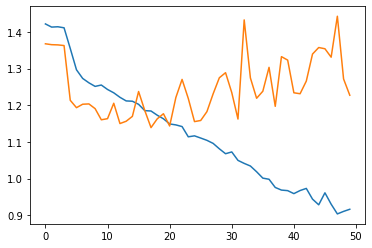

In [ ]:
plt.plot(range(epochs), epoch_loss_arr)
plt.plot(range(epochs), epoch_valid_loss_arr)
plt.show()

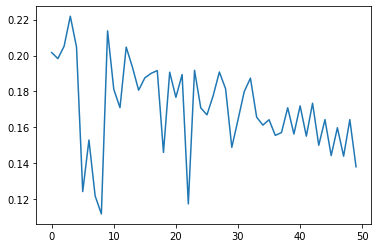

In [ ]:
epoch_valid_MCC_arr_plottable = [epoch_valid_MCC_arr[i].to('cpu').numpy() if epoch_valid_MCC_arr[i] != 0 else 0.0 for i, se in enumerate(epoch_valid_MCC_arr)]
plt.plot(range(epochs), epoch_valid_MCC_arr_plottable)
plt.show()

And the PSSM model

Epoch: 0 Current loss: 1.4228093878924846
Epoch: 0 Current loss: 1.4233827298879624
Epoch: 0 Current loss: 1.4000496780872345
Epoch 0 finished with 1.4021906920108307  


Epoch: 20 Current loss: 1.0676055026054383
Epoch: 20 Current loss: 1.0886182487756013
Epoch: 20 Current loss: 1.0575326807051897
Epoch 20 finished with 1.0670988019831569  


Epoch: 40 Current loss: 0.881958469748497
Epoch: 40 Current loss: 0.8928863363713027
Epoch: 40 Current loss: 0.8730241520702839
Epoch 40 finished with 0.894081770631699  




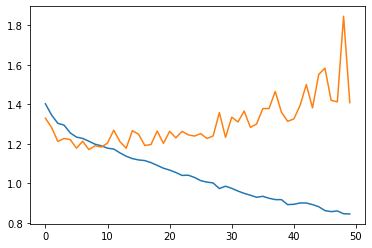

In [ ]:
lamb=0.001
lr = 0.001
epochs = 50
new_pssm_model = FCN_Net()
optimizer = optim.SGD(new_pssm_model.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_pssm_loader)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

epoch_loss_arr = []
epoch_valid_loss_arr = []
epoch_valid_MCC_arr = []
train_validation_loop_with_mcc(epochs, optimizer, new_pssm_model, criterion, train_pssm_loader, validation_pssm_loader, device)

plt.plot(range(epochs), epoch_loss_arr)
plt.plot(range(epochs), epoch_valid_loss_arr)
plt.show()

#### Tuning Hyperparameters

In [ ]:
#pip install -U ray

In [ ]:
# Note ray often needs to be reinstalled, so uncomment and install this if the following imports do not work
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

From our above analysis of manually changing parameters we see improvements to the loss are made fairly quickly, hence our justification for a grace period of 10. We also see after 30-40 epochs from using different parameters, the one-hot model overfits, therefore we will not run our training loop for longer than this. For the pssm model, these epochs will be lowered to 20. This approach is similar to early stopping, but has been done by inspection. From manual experimentation we also see a lower learning rate and weight decay is more optimal, therefore we have selected values in this range to be experimented on.

In [ ]:
def train_and_eval(config):
    
    # Call the remote function and pass in the object reference as memory issues occur trying to access the global variables, or passing them in locally
    train_loader = ray.get(train_object_ref)
    valid_loader = ray.get(validation_object_ref)

    lamb = config['lamb']
    lr = config['lr']
    epochs = config['epochs']
    model = FCN_Net()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
    use_cuda = True
    device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
    disordered_loss_weight = loss_weight_multiplier(train_loader)
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))
    
    model = model.to(device)
    best_val_loss = float('inf')
    for epoch in range(0, epochs):

        # Training data handling
        total_epoch_loss = 0.0
        train_iter = iter(train_loader)

        model.train()
        for i, sam in enumerate(train_iter):
          acc, seq, label = sam.values()
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          output = model(NN_input)
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)
          optimizer.zero_grad()
          loss.backward()
          total_epoch_loss += loss.item()
          optimizer.step()
        

        # Validation data handling
        model.eval()
        valid_iter = iter(valid_loader)
        total_loss_valid = 0
        total_MCC_valid = 0
        for i, sam in enumerate(valid_iter):
          acc, seq, label = sam.values()
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          with torch.no_grad():
            output = model(NN_input)
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)          
          total_loss_valid += loss.item()

          total_MCC_valid += calc_MCC(pred_round(torch.sigmoid(squeezed_o)), squeezed_e_o)

        # Validation statistics for selecting best hyperparameters
        average_loss = total_loss_valid / len(valid_loader)
        average_mcc = total_MCC_valid / len(valid_loader)

        if average_loss < best_val_loss:
          best_val_loss = average_loss
          with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
            path = drive_checkpoint_dir + '/checkpoint'
            torch.save(model.state_dict(), path)

        tune.report(loss=best_val_loss) #, mcc=average_mcc)


In [ ]:
config = {
    "lr": tune.choice([0.0005, 0.001, 0.005, 0.01]),
    "lamb": tune.choice([0.001, 0.005, 0.01]),
    "epochs": 40
}

ray.init(num_gpus=1, ignore_reinit_error=True)

# Create references for data loaders due to memory issues
train_object_ref = ray.put(train_loader)
validation_object_ref = ray.put(validation_loader)

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    grace_period=10
)

reporter = CLIReporter()

drive_checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/ray_results'

analysis = tune.run(
    train_and_eval,
    config=config,
    resources_per_trial=tune.PlacementGroupFactory(
        [{'GPU': 1.0, 'CPU': 1.0}] + [{'CPU': 1.0}] * 1
    ),
    num_samples=10,
    local_dir=drive_checkpoint_dir,
    scheduler=scheduler,
    progress_reporter=reporter,
)


2023-03-12 15:32:30,186	INFO worker.py:1553 -- Started a local Ray instance.
2023-03-12 15:32:34,996	INFO tensorboardx.py:170 -- pip install "ray[tune]" to see TensorBoard files.
2023-03-12 15:32:34,997	WARNING callback.py:108 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2023-03-12 15:32:40 (running for 00:00:05.53)
Memory usage on this node: 5.8/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_15-32-34
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+-------------------+--------+--------+
| Trial name                 | status   | loc               |   lamb |     lr |
|----------------------------+----------+-------------------+--------+--------|
| train_and_eval_1cb70_00000 | RUNNING  | 172.28.0.12:58331 |  0.001 | 0.0005 |
| train_and_eval_1cb70_00001 | PENDING  |                   |  0.001 | 0.005  |
| train_and_eval_1cb70_00002 | PENDING  |                   |  0.01  | 0.005  |
| train_and_eval_1cb70_00003 | PENDING  |                   |  0.001 | 0.01   |
| train_a

(train_and_eval pid=58331) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=58331)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 15:32:45 (running for 00:00:10.55)
Memory usage on this node: 7.0/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_15-32-34
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+-------------------+--------+--------+
| Trial name                 | status   | loc               |   lamb |     lr |
|----------------------------+----------+-------------------+--------+--------|
| train_and_eval_1cb70_00000 | RUNNING  | 172.28.0.12:58331 |  0.001 | 0.0005 |
| train_and_eval_1cb70_00001 | PENDING  |                   |  0.001 | 0.005  |
| train_and_eval_1cb70_00002 | PENDING  |                   |  0.01  | 0.005  |
| train_and_eval_1cb70_00003 | PENDING  |                   |  0.001 | 0.01   |
| train_a

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_and_eval_1cb70_00000,2023-03-12_15-38-22,True,,1bff40c954914dd2a051686ad9d99028,591b3c17ca68,40,1.12948,172.28.0.12,58331,341.734,14.9452,341.734,1678635502,0,,40,1cb70_00000,0.00694776
train_and_eval_1cb70_00001,2023-03-12_15-39-59,True,,ec295ee62697453caf7c1ffe832e52ef,591b3c17ca68,10,1.23399,172.28.0.12,59922,87.8116,7.14795,87.8116,1678635599,0,,10,1cb70_00001,0.00434518
train_and_eval_1cb70_00002,2023-03-12_15-41-35,True,,04d72de67eec4046b9d8409dba60b1ce,591b3c17ca68,10,1.36525,172.28.0.12,60398,88.877,7.54272,88.877,1678635695,0,,10,1cb70_00002,0.00499177
train_and_eval_1cb70_00003,2023-03-12_15-43-07,True,,397f9be3b3614731b6021c1ef37aaaf8,591b3c17ca68,10,1.36503,172.28.0.12,60859,89.4605,8.8508,89.4605,1678635787,0,,10,1cb70_00003,0.00398445
train_and_eval_1cb70_00004,2023-03-12_15-44-39,True,,d3308150e36346cb907e02c51c5131bd,591b3c17ca68,10,1.36504,172.28.0.12,61323,86.0113,8.06007,86.0113,1678635879,0,,10,1cb70_00004,0.0058949
train_and_eval_1cb70_00005,2023-03-12_15-46-09,True,,c1d7a2461e8847678acd911fdfda917b,591b3c17ca68,10,1.36501,172.28.0.12,61766,87.1038,7.86219,87.1038,1678635969,0,,10,1cb70_00005,0.00398111
train_and_eval_1cb70_00006,2023-03-12_15-51-58,True,,973078eac1c8478eb7843f6bcc209763,591b3c17ca68,40,1.13206,172.28.0.12,62215,345.341,8.33003,345.341,1678636318,0,,40,1cb70_00006,0.00448108
train_and_eval_1cb70_00007,2023-03-12_15-53-38,True,,478503397a6945fba18de0cc5585233d,591b3c17ca68,10,1.36487,172.28.0.12,63807,95.3744,6.73031,95.3744,1678636418,0,,10,1cb70_00007,0.00495815
train_and_eval_1cb70_00008,2023-03-12_15-55-13,True,,5a77401ee0b14c2ba325f4aa5864971a,591b3c17ca68,10,1.36499,172.28.0.12,64298,90.1783,8.45574,90.1783,1678636513,0,,10,1cb70_00008,0.00682473
train_and_eval_1cb70_00009,2023-03-12_15-56-49,True,,7355c762b3af445286dd88a32b8dbcc2,591b3c17ca68,10,1.36497,172.28.0.12,64765,92.5612,12.5509,92.5612,1678636609,0,,10,1cb70_00009,0.00396132


== Status ==
Current time: 2023-03-12 15:33:01 (running for 00:00:26.42)
Memory usage on this node: 8.1/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_15-32-34
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status   | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+----------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1cb70_00000 | RUNNING  | 172.28.0.12:58331 |  0.001 | 0.0005 |      1 |          15.8465 | 1.36687 |
| train_and_eval_1cb70_00001 | PENDING  |                   |  0.001 | 0.005  |        |         

(train_and_eval pid=59922) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=59922)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 15:38:36 (running for 00:06:01.88)
Memory usage on this node: 6.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: -1.1294847950828415 | Iter 10.000: -1.1724212144866293
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_15-32-34
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1cb70_00001 | RUNNING    | 172.28.0.12:59922 |  0.001 | 0.005  |        |                  |         |
| train_and_eval_1cb70_00002 | PENDING    |  

(train_and_eval pid=60398) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=60398)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 15:40:11 (running for 00:07:36.32)
Memory usage on this node: 6.2/12.7 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 40.000: -1.1294847950828415 | Iter 10.000: -1.1878127730257924
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_15-32-34
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1cb70_00002 | RUNNING    | 172.28.0.12:60398 |  0.01  | 0.005  |        |                  |         |
| train_and_eval_1cb70_00003 | PENDING    |  

(train_and_eval pid=60859) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=60859)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 15:41:40 (running for 00:09:05.74)
Memory usage on this node: 5.7/12.7 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 40.000: -1.1294847950828415 | Iter 10.000: -1.2032043315649554
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_15-32-34
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1cb70_00003 | RUNNING    | 172.28.0.12:60859 |  0.001 | 0.01   |        |                  |         |
| train_and_eval_1cb70_00004 | PENDING    |  

(train_and_eval pid=61323) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=61323)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 15:43:13 (running for 00:10:38.76)
Memory usage on this node: 5.6/12.7 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 40.000: -1.1294847950828415 | Iter 10.000: -1.2185958901041185
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_15-32-34
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1cb70_00004 | RUNNING    | 172.28.0.12:61323 |  0.005 | 0.005  |        |                  |         |
| train_and_eval_1cb70_00005 | PENDING    |  

(train_and_eval pid=61766) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=61766)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 15:44:44 (running for 00:12:09.75)
Memory usage on this node: 5.6/12.7 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 40.000: -1.1294847950828415 | Iter 10.000: -1.2339874486432816
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_15-32-34
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1cb70_00005 | RUNNING    | 172.28.0.12:61766 |  0.005 | 0.01   |        |                  |         |
| train_and_eval_1cb70_00006 | PENDING    |  

(train_and_eval pid=62215) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=62215)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 15:46:14 (running for 00:13:39.79)
Memory usage on this node: 5.7/12.7 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 40.000: -1.1294847950828415 | Iter 10.000: -1.266742342443122
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_15-32-34
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1cb70_00006 | RUNNING    | 172.28.0.12:62215 |  0.005 | 0.001  |        |                  |         |
| train_and_eval_1cb70_00007 | PENDING    |   

(train_and_eval pid=63807) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=63807)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 15:52:03 (running for 00:19:28.96)
Memory usage on this node: 5.8/12.7 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 40.000: -1.1301297560513541 | Iter 10.000: -1.203721892422868
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_15-32-34
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1cb70_00007 | RUNNING    | 172.28.0.12:63807 |  0.01  | 0.001  |        |                  |         |
| train_and_eval_1cb70_00008 | PENDING    |   

(train_and_eval pid=64298) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=64298)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 15:53:43 (running for 00:21:08.85)
Memory usage on this node: 5.9/12.7 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 40.000: -1.1301297560513541 | Iter 10.000: -1.2188546705330747
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_15-32-34
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1cb70_00008 | RUNNING    | 172.28.0.12:64298 |  0.005 | 0.01   |        |                  |         |
| train_and_eval_1cb70_00009 | PENDING    |  

(train_and_eval pid=64765) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=64765)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 15:55:18 (running for 00:22:43.86)
Memory usage on this node: 5.7/12.7 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 40.000: -1.1301297560513541 | Iter 10.000: -1.2339874486432816
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_15-32-34
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1cb70_00009 | RUNNING    | 172.28.0.12:64765 |  0.01  | 0.01   |        |                  |         |
| train_and_eval_1cb70_00000 | TERMINATED | 172.28.0.12:

2023-03-12 15:56:49,061	INFO tune.py:798 -- Total run time: 1454.13 seconds (1454.01 seconds for the tuning loop).


== Status ==
Current time: 2023-03-12 15:56:49 (running for 00:24:14.05)
Memory usage on this node: 8.0/12.7 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 40.000: -1.1301297560513541 | Iter 10.000: -1.2667077770966149
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_15-32-34
Number of trials: 10/10 (10 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1cb70_00000 | TERMINATED | 172.28.0.12:58331 |  0.001 | 0.0005 |     40 |         341.734  | 1.12948 |
| train_and_eval_1cb70_00001 | TERMINATED | 172.28.0.12:59922 |  0.001

We can see in the above table that the higher learning rate performed worse than smaller ones. <br>Our best parameters:

In [ ]:
best_trial = analysis.get_best_trial(metric="loss", mode="min")
print(best_trial)
best_config = best_trial.config
print(best_config)
best_lamb = best_trial.config["lamb"]
print(best_lamb)
best_lr = best_trial.config["lr"]
print(best_lr)

train_and_eval_1cb70_00000
{'lr': 0.0005, 'lamb': 0.001, 'epochs': 40}
0.001
0.0005


And PSSMs.

In [ ]:
config = {
    "lr": tune.choice([0.0005, 0.001, 0.005, 0.01]),
    "lamb": tune.choice([0.001, 0.005, 0.01]),
    "epochs": 20
}

ray.init(num_gpus=1, ignore_reinit_error=True)

# Create references for data loaders due to memory issues
train_object_ref = ray.put(train_pssm_loader)
validation_object_ref = ray.put(validation_pssm_loader)

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    grace_period=10
)

reporter = CLIReporter()

drive_checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/ray_results'

pssm_analysis = tune.run(
    train_and_eval,
    config=config,
    resources_per_trial=tune.PlacementGroupFactory(
        [{'GPU': 1.0, 'CPU': 1.0}] + [{'CPU': 1.0}] * 1
    ),
    num_samples=10,
    local_dir=drive_checkpoint_dir,
    scheduler=scheduler,
    progress_reporter=reporter,
)

2023-03-12 16:19:23,477	INFO worker.py:1382 -- Calling ray.init() again after it has already been called.
2023-03-12 16:19:23,843	WARNING callback.py:108 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2023-03-12 16:19:27 (running for 00:00:03.30)
Memory usage on this node: 6.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_16-19-23
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+-------------------+--------+-------+
| Trial name                 | status   | loc               |   lamb |    lr |
|----------------------------+----------+-------------------+--------+-------|
| train_and_eval_a6eb2_00000 | RUNNING  | 172.28.0.12:71268 |  0.001 | 0.005 |
| train_and_eval_a6eb2_00001 | PENDING  |                   |  0.005 | 0.01  |
| train_and_eval_a6eb2_00002 | PENDING  |                   |  0.001 | 0.01  |
| train_and_eval_a6eb2_00003 | PENDING  |                   |  0.01  | 0.01  |
| train_and_eval

(train_and_eval pid=71268) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=71268)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 16:19:32 (running for 00:00:08.32)
Memory usage on this node: 6.5/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_16-19-23
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+-------------------+--------+-------+
| Trial name                 | status   | loc               |   lamb |    lr |
|----------------------------+----------+-------------------+--------+-------|
| train_and_eval_a6eb2_00000 | RUNNING  | 172.28.0.12:71268 |  0.001 | 0.005 |
| train_and_eval_a6eb2_00001 | PENDING  |                   |  0.005 | 0.01  |
| train_and_eval_a6eb2_00002 | PENDING  |                   |  0.001 | 0.01  |
| train_and_eval_a6eb2_00003 | PENDING  |                   |  0.01  | 0.01  |
| train_and_eval

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_and_eval_a6eb2_00000,2023-03-12_16-22-12,True,,57c82d839a75449b801a8249d997380e,591b3c17ca68,20,1.36498,172.28.0.12,71268,165.317,6.89101,165.317,1678638132,0,,20,a6eb2_00000,0.00623727
train_and_eval_a6eb2_00001,2023-03-12_16-25-00,True,,595584e18fc54af7828e6b7a1125fa79,591b3c17ca68,20,1.36498,172.28.0.12,72031,163.473,8.25512,163.473,1678638300,0,,20,a6eb2_00001,0.00745201
train_and_eval_a6eb2_00002,2023-03-12_16-27-52,True,,ccdfa687fbe24811815ceb0ac1250e24,591b3c17ca68,20,1.35721,172.28.0.12,72792,168.891,7.95005,168.891,1678638472,0,,20,a6eb2_00002,0.00396848
train_and_eval_a6eb2_00003,2023-03-12_16-29-25,True,,d7a2d906ed414d6ebaf407bc83cd5e37,591b3c17ca68,10,1.36503,172.28.0.12,73578,89.5709,7.19251,89.5709,1678638565,0,,10,a6eb2_00003,0.00387836
train_and_eval_a6eb2_00004,2023-03-12_16-30-56,True,,a69e9a3ab6ca48c3975742780985b117,591b3c17ca68,10,1.36498,172.28.0.12,74018,86.7429,7.40933,86.7429,1678638656,0,,10,a6eb2_00004,0.00492692
train_and_eval_a6eb2_00005,2023-03-12_16-33-45,True,,e851ada89e33470eb197e75a550a75ce,591b3c17ca68,20,1.14976,172.28.0.12,74452,165.74,8.09588,165.74,1678638825,0,,20,a6eb2_00005,0.00416875
train_and_eval_a6eb2_00006,2023-03-12_16-35-16,True,,b02e631ea64d4635b5e1ae5782a5d534,591b3c17ca68,10,1.36498,172.28.0.12,75217,87.2007,6.73698,87.2007,1678638916,0,,10,a6eb2_00006,0.00394726
train_and_eval_a6eb2_00007,2023-03-12_16-36-58,True,,7f085698d5c64206a913d19e88046fe1,591b3c17ca68,10,1.3655,172.28.0.12,75647,96.7777,7.73426,96.7777,1678639018,0,,10,a6eb2_00007,0.00474524
train_and_eval_a6eb2_00008,2023-03-12_16-39-47,True,,fee5e9b7624940e59b5b82122b01c449,591b3c17ca68,20,1.16742,172.28.0.12,76132,166.233,6.83113,166.233,1678639187,0,,20,a6eb2_00008,0.00380778
train_and_eval_a6eb2_00009,2023-03-12_16-41-17,True,,ee9e918ad8ec465fb9cedc305fecfd86,591b3c17ca68,10,1.36498,172.28.0.12,76904,86.5903,8.36453,86.5903,1678639277,0,,10,a6eb2_00009,0.00468755


== Status ==
Current time: 2023-03-12 16:19:48 (running for 00:00:24.28)
Memory usage on this node: 8.7/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_16-19-23
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+-------------------+--------+-------+--------+------------------+--------+
| Trial name                 | status   | loc               |   lamb |    lr |   iter |   total time (s) |   loss |
|----------------------------+----------+-------------------+--------+-------+--------+------------------+--------|
| train_and_eval_a6eb2_00000 | RUNNING  | 172.28.0.12:71268 |  0.001 | 0.005 |      1 |          15.9331 | 1.3657 |
| train_and_eval_a6eb2_00001 | PENDING  |                   |  0.005 | 0.01  |        |                  

(train_and_eval pid=72031) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=72031)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 16:22:18 (running for 00:02:54.27)
Memory usage on this node: 6.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: -1.3649803384388564
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_16-19-23
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------------+------------+-------------------+--------+-------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |    lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+-------+--------+------------------+---------|
| train_and_eval_a6eb2_00001 | RUNNING    | 172.28.0.12:72031 |  0.005 | 0.01  |        |                  |         |
| train_and_eval_a6eb2_00002 | PENDING    |                   | 

(train_and_eval pid=72792) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=72792)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 16:25:06 (running for 00:05:42.28)
Memory usage on this node: 6.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: -1.3649798747747157
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_16-19-23
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------+------------+-------------------+--------+-------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |    lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+-------+--------+------------------+---------|
| train_and_eval_a6eb2_00002 | RUNNING    | 172.28.0.12:72792 |  0.001 | 0.01  |        |                  |         |
| train_and_eval_a6eb2_00003 | PENDING    |                   | 

(train_and_eval pid=73578) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=73578)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 16:27:58 (running for 00:08:34.36)
Memory usage on this node: 6.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: -1.3643183074320953
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_16-19-23
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------------+------------+-------------------+--------+-------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |    lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+-------+--------+------------------+---------|
| train_and_eval_a6eb2_00003 | RUNNING    | 172.28.0.12:73578 |  0.01  | 0.01  |        |                  |         |
| train_and_eval_a6eb2_00004 | PENDING    |                   | 

(train_and_eval pid=74018) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=74018)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 16:29:31 (running for 00:10:07.37)
Memory usage on this node: 6.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 40.000: None | Iter 10.000: -1.3646490138260488
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_16-19-23
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+----------------------------+------------+-------------------+--------+-------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |    lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+-------+--------+------------------+---------|
| train_and_eval_a6eb2_00004 | RUNNING    | 172.28.0.12:74018 |  0.01  | 0.005 |        |                  |         |
| train_and_eval_a6eb2_00005 | PENDING    |                   | 

(train_and_eval pid=74452) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=74452)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 16:31:02 (running for 00:11:38.40)
Memory usage on this node: 6.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 40.000: None | Iter 10.000: -1.3649753086937335
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_16-19-23
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+----------------------------+------------+-------------------+--------+-------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |    lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+-------+--------+------------------+---------|
| train_and_eval_a6eb2_00005 | RUNNING    | 172.28.0.12:74452 |  0.005 | 0.001 |        |                  |         |
| train_and_eval_a6eb2_00006 | PENDING    |                   | 

(train_and_eval pid=75217) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=75217)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 16:33:51 (running for 00:14:27.40)
Memory usage on this node: 6.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 40.000: None | Iter 10.000: -1.3639864981565748
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_16-19-23
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+----------------------------+------------+-------------------+--------+-------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |    lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+-------+--------+------------------+---------|
| train_and_eval_a6eb2_00006 | RUNNING    | 172.28.0.12:75217 |  0.01  | 0.01  |        |                  |         |
| train_and_eval_a6eb2_00007 | PENDING    |                   | 

(train_and_eval pid=75647) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=75647)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 16:35:22 (running for 00:15:58.43)
Memory usage on this node: 6.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 40.000: None | Iter 10.000: -1.364316101668961
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_16-19-23
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+----------------------------+------------+-------------------+--------+-------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |    lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+-------+--------+------------------+---------|
| train_and_eval_a6eb2_00007 | RUNNING    | 172.28.0.12:75647 |  0.001 | 0.005 |        |                  |         |
| train_and_eval_a6eb2_00008 | PENDING    |                   |  

(train_and_eval pid=76132) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=76132)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 16:37:03 (running for 00:17:39.49)
Memory usage on this node: 6.4/12.7 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 40.000: None | Iter 10.000: -1.3646457051813472
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_16-19-23
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+----------------------------+------------+-------------------+--------+-------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |    lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+-------+--------+------------------+---------|
| train_and_eval_a6eb2_00008 | RUNNING    | 172.28.0.12:76132 |  0.001 | 0.001 |        |                  |         |
| train_and_eval_a6eb2_00009 | PENDING    |                   | 

(train_and_eval pid=76904) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=76904)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 16:39:53 (running for 00:20:29.46)
Memory usage on this node: 6.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 40.000: None | Iter 10.000: -1.3636568946441885
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_16-19-23
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+----------------------------+------------+-------------------+--------+-------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |    lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+-------+--------+------------------+---------|
| train_and_eval_a6eb2_00009 | RUNNING    | 172.28.0.12:76904 |  0.005 | 0.01  |        |                  |         |
| train_and_eval_a6eb2_00000 | TERMINATED | 172.28.0.12:71268 |  0.001 | 0.

2023-03-12 16:41:17,807	INFO tune.py:798 -- Total run time: 1313.97 seconds (1313.90 seconds for the tuning loop).


== Status ==
Current time: 2023-03-12 16:41:17 (running for 00:21:53.95)
Memory usage on this node: 8.1/12.7 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 40.000: None | Iter 10.000: -1.3639864981565748
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_16-19-23
Number of trials: 10/10 (10 TERMINATED)
+----------------------------+------------+-------------------+--------+-------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |    lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+-------+--------+------------------+---------|
| train_and_eval_a6eb2_00000 | TERMINATED | 172.28.0.12:71268 |  0.001 | 0.005 |     20 |         165.317  | 1.36498 |
| train_and_eval_a6eb2_00001 | TERMINATED | 172.28.0.12:72031 |  0.005 | 0.01  |     20 |

In [ ]:
best_trial = pssm_analysis.get_best_trial(metric="loss", mode="min")
print(best_trial)
best_config = best_trial.config
print(best_config)
best_lamb = best_trial.config["lamb"]
print(best_lamb)
best_lr = best_trial.config["lr"]
print(best_lr)

train_and_eval_a6eb2_00005
{'lr': 0.001, 'lamb': 0.005, 'epochs': 20}
0.005
0.001


### Training final models

In [ ]:
def full_train(epochs, optimizer, model, loss_fn, train_loader, device):
    model = model.to(device)
    model.train()
    for epoch in range(0, epochs):
        
        running_loss_train = 0.0
        total_epoch_loss = 0.0
        train_iter = iter(train_loader)

        for i, sam in enumerate(train_iter):
          acc, seq, label = sam.values()
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          # Output is the predictions
          output = model(NN_input)
          # Squeeze as we are treating each sequence as a batch, where the amino acids have been classified
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          running_loss_train += loss.item()
          total_epoch_loss += loss.item()

        # Separates printed epochs
        if epoch == 0 or epoch % epoch_print_gap == 0:
          print("Epoch", epoch, "finished with", (total_epoch_loss/len(train_loader))," \n\n")

In [ ]:
full_training_dataset = non_leaking_dataset_split['Train'] + non_leaking_dataset_split['Validation']
total_train_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, full_training_dataset)

train_loader = DataLoader(total_train_dataset, batch_size=1,
                        shuffle=True, num_workers=0)


lamb = 0.001 #analysis.get_best_trial(metric="loss", mode="min").config["lamb"]
lr = 0.0005 #analysis.get_best_trial(metric="loss", mode="min").config["lr"]
epochs = 40
epoch_print_gap = 20
final_fcn_model_one_hot = FCN_Net()
optimizer = optim.SGD(final_fcn_model_one_hot.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_loader)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

full_train(epochs, optimizer, final_fcn_model_one_hot, loss_fn, train_loader, device)

Epoch 0 finished with 1.4360633193986414  


Epoch 20 finished with 1.1578185285450684  




In [ ]:
full_training_dataset = non_leaking_dataset_split['Train'] + non_leaking_dataset_split['Validation']
total_pssm_train_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, full_training_dataset)

train_pssm_loader = DataLoader(total_pssm_train_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

# Due to Colab's limited run time these have been filled in manually from being printed out in the Notebook.
# To recomplete the full experiment, add the analysis best value lookups back in.
lamb = 0.005 #pssm_analysis.get_best_trial(metric="loss", mode="min").config["lamb"]
lr = 0.001 #pssm_analysis.get_best_trial(metric="loss", mode="min").config["lr"]
epochs = 20
epoch_print_gap = 5
final_fcn_model_pssm = FCN_Net()
optimizer = optim.SGD(final_fcn_model_pssm.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_pssm_loader)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

full_train(epochs, optimizer, final_fcn_model_pssm, loss_fn, train_pssm_loader, device)

Epoch 0 finished with 1.4071905810502896  


Epoch 5 finished with 1.251007970159838  


Epoch 10 finished with 1.219063068703162  


Epoch 15 finished with 1.1967495123074954  




Evaluating MCC over entire test dataset.

In [ ]:
def calculate_dataset_mcc(name, dataset, model):
  test_mcc_score = 0

  model.eval()
  for seq in dataset:
    input_seq = seq.get('seq')
    input_seq = input_seq.type(torch.FloatTensor)
    input_seq = input_seq.to(device)
    true_label = seq.get('label')
    true_label = true_label.type(torch.FloatTensor)
    true_label = true_label.to(device)

    with torch.no_grad():
      predicted_label = model(input_seq)
    
    predicted_label = torch.sigmoid(predicted_label)
    predicted_label = torch.squeeze(predicted_label)
    true_label = torch.squeeze(true_label)

    pred_lab = pred_round(predicted_label)
    test_mcc_score += calc_MCC(pred_lab, true_label)

  print(name+" MCC score: ", ( test_mcc_score / len(dataset) ))

In [ ]:
calculate_dataset_mcc("Test", test_loader, final_fcn_model_one_hot)
calculate_dataset_mcc("Test", test_pssm_loader, final_fcn_model_pssm)

Test MCC score:  tensor(0.2061, device='cuda:0')
Test MCC score:  tensor(0.2422, device='cuda:0')


### Saving model - for later use.

In [ ]:
# Writes trained model to storage
def write_model(model, fname):

  model = model.to("cpu")
  PATH = '/content/drive/My Drive/Colab Notebooks/diss_files/'+fname
  torch.save(model.state_dict(), PATH)

#write_model(final_fcn_model_one_hot, '1hot_1D_cnn_net.pth')
#write_model(final_fcn_model_pssm, 'pssm_1D_cnn_net.pth')

In [ ]:
def write_weights(model, fname):

  model = model.to("cpu")
  PATH = '/content/drive/My Drive/Colab Notebooks/diss_files/'+fname
  torch.save(model.state_dict(), PATH)

#write_model(final_fcn_model_one_hot, '1hot_1D_cnn_net.pt')
#write_model(final_fcn_model_pssm, 'pssm_1D_cnn_net.pt')

### Training the model on all of DisProt

In [ ]:
full_training_dataset = non_leaking_dataset_split['Train'] + non_leaking_dataset_split['Validation'] + non_leaking_dataset_split['Test']
total_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, full_training_dataset)

train_loader = DataLoader(total_dataset, batch_size=1,
                        shuffle=True, num_workers=0)


lamb = 0.001
lr = 0.0005
epochs = 40
epoch_print_gap = 20
final_fcn_model_one_hot = FCN_Net()
optimizer = optim.SGD(final_fcn_model_one_hot.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_loader)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

full_train(epochs, optimizer, final_fcn_model_one_hot, loss_fn, train_loader, device)

Epoch 0 finished with 1.4500501606166487  


Epoch 20 finished with 1.181047223882588  




In [ ]:
full_training_dataset = non_leaking_dataset_split['Train'] + non_leaking_dataset_split['Validation'] + non_leaking_dataset_split['Test']
total_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, full_training_dataset)

train_pssm_loader = DataLoader(total_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

lamb = 0.005
lr = 0.001
epochs = 20
epoch_print_gap = 5
final_fcn_model_pssm = FCN_Net()
optimizer = optim.SGD(final_fcn_model_pssm.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_pssm_loader)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

full_train(epochs, optimizer, final_fcn_model_pssm, loss_fn, train_pssm_loader, device)

Epoch 0 finished with 1.431483650242159  


Epoch 5 finished with 1.2811547650272492  


Epoch 10 finished with 1.2631729448692786  


Epoch 15 finished with 1.2337346976849488  




In [ ]:
write_model(final_fcn_model_one_hot, 'full_1hot_1D_cnn_net.pth')
write_model(final_fcn_model_pssm, 'full_pssm_1D_cnn_net.pth')

write_model(final_fcn_model_one_hot, 'full_1hot_1D_cnn_net.pt')
write_model(final_fcn_model_pssm, 'full_pssm_1D_cnn_net.pt')